In [1]:
%matplotlib inline
%pylab inline
import matplotlib.pyplot as plt
import seaborn as sns

from os import listdir, makedirs
from os.path import join, isfile, exists, dirname
import gc
import re

import numpy as np
import pandas as pd
from tqdm._tqdm_notebook import tqdm_notebook
from gensim.corpora import Dictionary, MmCorpus
from gensim.models import TfidfModel, LdaModel, Word2Vec, Doc2Vec, FastText, CoherenceModel

from constants import *
from topic_reranking import TopicsLoader, Reranker
from utils import load

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

tqdm_notebook.pandas()
pd.options.display.max_columns = 500
pd.options.display.max_rows = 1000
pd.options.display.precision = 3
pd.options.display.width = 2000

Populating the interactive namespace from numpy and matplotlib


-----

### Loading embeddings

In [2]:
d2v = load('d2v').docvecs
w2v = load('w2v').wv
ftx = load('ftx').wv

# Dry run to make sure both indices are fully in RAM
d2v.init_sims()
vector = d2v.vectors_docs_norm[0]
d2v.index2entity[0]
d2v.most_similar([vector], topn=5)

w2v.init_sims()
vector = w2v.vectors_norm[0]
w2v.index2entity[0]
w2v.most_similar([vector], topn=5)

ftx.init_sims()
vector = ftx.vectors_norm[0]
ftx.index2entity[0]
ftx.most_similar([vector], topn=5)

kvs = {'d2v': d2v, 'w2v': w2v, 'ftx': ftx}

Reading ../data/preprocessed/embeddings/d2v/d2v
Reading ../data/preprocessed/embeddings/w2v/w2v
Reading ../data/preprocessed/embeddings/ftx/ftx
8952056961092092653
der
der


------

### Vector-based reranking

In [3]:
#nb_topics = 1
version = 'noun'
nb_candidate_terms = 20
nb_top_terms = 10

In [4]:
def _rank(df, name):
    df[f'{name}_drank'] = df[f'{name}_dscore'].rank().map(lambda x: x-1)
    df[f'{name}_rrank'] = df[f'{name}_rscore'].rank().map(lambda x: x-1)
    return df

def fillna_max(df):
    mask = df.isnull().any(axis=1)
    df[mask] = df[mask].apply(lambda x: x.fillna(x.max()), axis=1)
    return df

def rerank(topic_param):
    reference = pd.Series(np.arange(nb_candidate_terms), index=topic_param, name='ref_rank')
    scores = [reference]
    for name, kv in kvs.items():
        in_kv = np.vectorize(lambda x: x in kv)
        mask = in_kv(topic_param)
        topic = topic_param[mask]
        not_in_kv = topic_param[~mask]
        nb_terms_in_vocab = len(topic)
        rank_scores = defaultdict(int)
        dist_scores = defaultdict(float)
        for i in range(nb_terms_in_vocab):
            entity = topic[i]
            others = np.delete(topic, i)
            distances = kv.distances(entity, tuple(others))
            argsort = distances.argsort()
            nearest = others[argsort]
            for j, term in zip(distances, others):
                dist_scores[term] += j
            for j, term in enumerate(nearest):
                rank_scores[term] += j
        d_score = pd.Series(dist_scores, name=f'{name}_dscore')
        r_score = pd.Series(rank_scores, name=f'{name}_rscore')
        dr = pd.concat([d_score, r_score], axis=1)
        dr = _rank(dr, name)
        scores.append(dr)
    df = pd.concat(scores, axis=1, sort=False)
    if df.isnull().any().any():
        for s in ['dscore', 'rscore', 'drank', 'rrank']:
            scols = df.columns.str.contains(s)
            df.loc[:, scols] = fillna_max(df.loc[:, scols])
    
    # getting scores and ranks for all combinations -> calculating c = a+b for both distance and rank scores 
    # and getting a rank for the sum
    for c, a, b in [('dw', 'd2v', 'w2v'), ('df', 'd2v', 'ftx'), ('wf', 'w2v', 'ftx'), ('dwf', 'dw', 'ftx')]:
        df[f'{c}_dscore'] = df[f'{a}_dscore'] + df[f'{b}_dscore']
        df[f'{c}_rscore'] = df[f'{a}_rscore'] + df[f'{b}_rscore']
        df = _rank(df, c)

    #print(df)
    return df

def sort_terms(col):
    top_terms = col.sort_values().index.values[:nb_top_terms]
    col = col[col.index.isin(top_terms)]
    return col.index.values

def remove_not_matching_terms(kv_name, topic):
    kv = kvs[kv_name]
    reduced_tpx = topic

    in_kv = np.vectorize(lambda x: x in kv)
    mask = in_kv(topic)
    reduced_tpx = topic[mask]
    not_in_kv = topic[~mask]
    nb_terms_in_kv = len(reduced_tpx)
    if nb_terms_in_kv > nb_top_terms:
        for i in range(nb_terms_in_kv - nb_top_terms):
            remove = kv.doesnt_match(reduced_tpx)
            reduced_tpx = reduced_tpx[reduced_tpx != remove]
    elif nb_terms_in_kv == 0:
        reduced_tpx = topic[:nb_top_terms]
    elif nb_terms_in_kv < nb_top_terms:
        nb_missing = nb_top_terms - nb_terms_in_kv
        for i, m in enumerate(mask):
            if not m:
                mask[i] = True
                nb_missing -= 1
                if nb_missing == 0:
                    break
        reduced_tpx = topic[mask]
        
    ser = pd.Series(reduced_tpx, name=kv_name + '_matches')
    return ser

def vote(df, reference, name='vote'):
    jury = (
        df
        .loc[:, 'term0':f'term{nb_top_terms-1}']
        .apply(pd.value_counts)
        .sum(axis=1)
        [reference]
        .dropna()
        .astype(np.int16)
        .reset_index()
        .rename(columns={'index':'term', 0:'count'})
        .sort_values('count', ascending=False, kind='mergesort')
        [:nb_top_terms]
        .set_index('term')
        .squeeze()
        [reference]
        .dropna()
        .reset_index()
        .rename(lambda x: f'term{x}')
        .drop('count', axis=1)
        .squeeze()
        .rename(name)
    )
    return jury

def calc_oop(col, df_ranks):
    terms = col.values
    ref_ranks = df_ranks.loc[terms, 'ref_rank']
    oop = (ref_ranks - np.arange(len(ref_ranks))).abs().sum()
    return oop

def full_rerank_and_everything(topic):
    topic = topic.values[0]

    df = rerank(topic)
    rank_columns = [col for col in df.columns if 'rank' in col]
    df_ranks = df[rank_columns]
    reranks = df_ranks.apply(sort_terms, axis=0).reset_index(drop=True).T.rename(columns=lambda x: f'term{x}')

    dred = remove_not_matching_terms('d2v', topic)
    wred = remove_not_matching_terms('w2v', topic)
    fred = remove_not_matching_terms('ftx', topic)
    reds = pd.concat([dred, wred, fred], axis=1).T.rename(columns=lambda x: f'term{x}')
    reranks = pd.concat([reranks, reds])

    votes = []
    for name in ['rrank', 'drank', 'matches', '']:
        x = reranks[reranks.index.str.contains(name)]
        v = vote(x, topic, f'{name}_vote'.strip('_'))
        votes.append(v)
    reranks = reranks.append(votes)

    reranks['oop_scores'] = reranks.apply(lambda x: calc_oop(x, df_ranks), axis=1)
    return reranks

def plot(scores):
    sns.set()
    pylab.rcParams['figure.figsize'] = (40, 15)
    scores.boxplot()

In [5]:
def score_and_plot(topics):
    result = topics.groupby(level=[0, 1, 2, 3], sort=False).progress_apply(full_rerank_and_everything)
    result.index = result.index.rename(names='metric', level=-1)
    scores = result.oop_scores.unstack('metric')
    #scores.describe()
    plot(scores)
    return result

param_ids = ['e42']
nbs_topics = [10, 25, 50, 100]

topics = []
for dataset in ['dewac', 'dewiki', 'dewa1', 'O', 'news', 'speeches', 'FA', 'FO', 'E', 'P']:
    topics_loader = TopicsLoader(
        dataset=dataset,
        param_ids=param_ids,
        nbs_topics=nbs_topics,
        version=version,
        topn=nb_candidate_terms
    )
    topics.append(topics_loader.topics)

topics = pd.concat(topics)

Loading dictionary from ../data/preprocessed/LDAmodel/noun/bow/dewac_noun_bow.dict
Loading model from ../data/preprocessed/LDAmodel/noun/bow/e42/dewac_LDAmodel_e42_10_ep30
Loading model from ../data/preprocessed/LDAmodel/noun/bow/e42/dewac_LDAmodel_e42_25_ep30
Loading model from ../data/preprocessed/LDAmodel/noun/bow/e42/dewac_LDAmodel_e42_50_ep30
Loading model from ../data/preprocessed/LDAmodel/noun/bow/e42/dewac_LDAmodel_e42_100_ep30
Loading dictionary from ../data/preprocessed/LDAmodel/noun/bow/dewiki_noun_bow.dict
Loading model from ../data/preprocessed/LDAmodel/noun/bow/e42/dewiki_LDAmodel_e42_10_ep30
Loading model from ../data/preprocessed/LDAmodel/noun/bow/e42/dewiki_LDAmodel_e42_25_ep30
Loading model from ../data/preprocessed/LDAmodel/noun/bow/e42/dewiki_LDAmodel_e42_50_ep30
Loading model from ../data/preprocessed/LDAmodel/noun/bow/e42/dewiki_LDAmodel_e42_100_ep30
Loading dictionary from ../data/preprocessed/LDAmodel/noun/bow/dewac1_noun_bow.dict
Loading model from ../data/prep

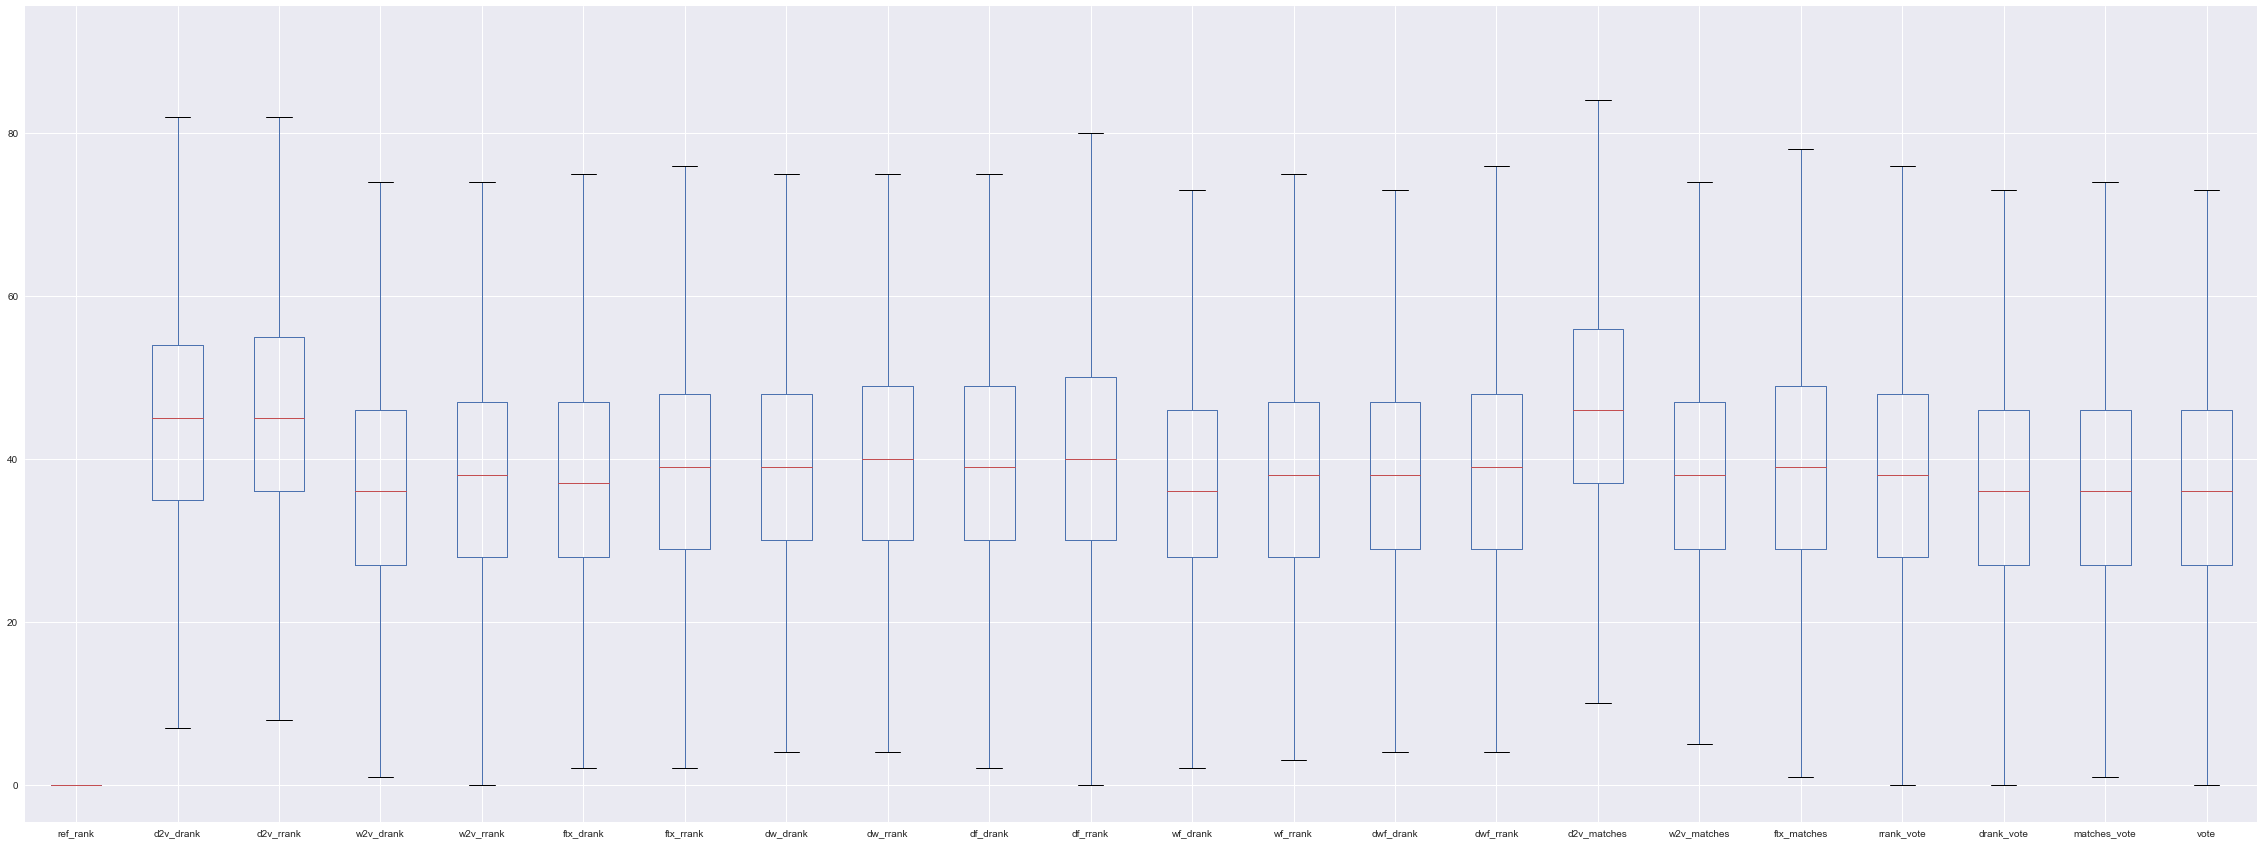

In [6]:
results = score_and_plot(topics)

In [7]:
#results.to_csv(join(TPX_PATH, ))
results

term0                     term1                     term2                 term3                 term4                   term5                   term6                   term7                 term8                     term9  oop_scores
dataset           param_id nb_topics topic_idx metric                                                                                                                                                                                                                                                               
dewac             e42      10        0         ref_rank                  Beitrag                       Uhr                     Seite               Antwort                  Bild                   Hallo                Internet                   Frage                 Thema               Information           0
                                               d2v_drank                 Beitrag                   Antwort                  Internet                 Frage           Information                   Forum                   Daten                    Link               Artikel                     Zitat          59
                                               d2v_rrank                 Beitrag                   Antwort                  Internet                 Frage           Information                   Forum                   Daten                    Link               Artikel                     Zitat          59
                                               w2v_drank                 Beitrag                   Antwort                      Bild              Internet                 Frage                   Thema             Information                   Daten               Artikel                     Zitat          43
                                               w2v_rrank                 Beitrag                   Antwort                      Bild              Internet                 Frage                   Thema             Information                   Daten               Artikel                     Zitat          43
                                               ftx_drank                 Beitrag                   Antwort                  Internet                 Frage                 Thema             Information                   Daten                    Fall               Artikel                     Zitat          54
                                               ftx_rrank                 Beitrag                   Antwort                  Internet                 Frage                 Thema             Information                   Daten                    Fall               Artikel                     Zitat          54
                                               dw_drank                  Beitrag                   Antwort                  Internet                 Frage                 Thema             Information                   Daten                    Link               Artikel                     Zitat          56
                                               dw_rrank                  Beitrag                   Antwort                  Internet                 Frage                 Thema             Information                   Daten                    Link               Artikel                     Zitat          56
                                               df_drank                  Beitrag                   Antwort                  Internet                 Frage                 Thema             Information                   Daten                    Link               Artikel                     Zitat          56
                                               df_rrank                  Beitrag                   Antwort                  Internet                 Frage                 Thema             Information                   Daten                    Link               Artikel                     Zitat          56
                                               wf_drank   

In [59]:
from difflib import SequenceMatcher

def cross_dist(topic, other):
    df = other.apply(lambda x: SequenceMatcher(a=topic, b=x, autojunk=False).ratio(), axis=1)
    return df.reset_index(['dataset', 'param_id', 'nb_topics', 'topic_idx'], drop=True)

def topic_dist(grp):
    df = grp.apply(lambda x: cross_dist(x, grp), axis=1)
    return df.reset_index(['dataset', 'param_id', 'nb_topics', 'topic_idx'], drop=True)

r = results.loc[:, :'term9'].groupby(['dataset', 'param_id', 'nb_topics', 'topic_idx'], sort=False).progress_apply(topic_dist)
r = r.groupby('metric', sort=False).mean()
r = r.loc[r.columns, :]
r

metric,ref_rank,d2v_drank,d2v_rrank,w2v_drank,w2v_rrank,ftx_drank,ftx_rrank,dw_drank,dw_rrank,df_drank,df_rrank,wf_drank,wf_rrank,dwf_drank,dwf_rrank,d2v_matches,w2v_matches,ftx_matches,rrank_vote,drank_vote,matches_vote,vote
metric,,,,,,,,,,,,,,,,,,,,,,
ref_rank,1.000,0.541,0.537,0.596,0.589,0.589,0.582,0.580,0.575,0.576,0.572,0.594,0.588,0.588,0.582,0.527,0.584,0.578,0.589,0.597,0.597,0.603
d2v_drank,0.541,1.000,0.926,0.685,0.676,0.691,0.681,0.790,0.816,0.796,0.812,0.688,0.681,0.758,0.766,0.850,0.671,0.678,0.766,0.767,0.706,0.770
d2v_rrank,0.537,0.926,1.000,0.665,0.673,0.674,0.679,0.771,0.821,0.779,0.819,0.671,0.678,0.740,0.771,0.828,0.651,0.660,0.774,0.742,0.684,0.757
w2v_drank,0.596,0.685,0.665,1.000,0.903,0.895,0.838,0.834,0.802,0.813,0.784,0.941,0.878,0.878,0.839,0.634,0.885,0.863,0.841,0.894,0.872,0.884
w2v_rrank,0.589,0.676,0.673,0.903,1.000,0.873,0.873,0.811,0.821,0.800,0.802,0.898,0.930,0.850,0.870,0.629,0.831,0.823,0.878,0.861,0.826,0.877
ftx_drank,0.589,0.691,0.674,0.895,0.873,1.000,0.908,0.815,0.801,0.836,0.815,0.947,0.907,0.881,0.862,0.638,0.842,0.873,0.865,0.898,0.856,0.897
ftx_rrank,0.582,0.681,0.679,0.838,0.873,0.908,1.000,0.784,0.805,0.814,0.831,0.881,0.933,0.841,0.879,0.630,0.787,0.823,0.886,0.850,0.806,0.872
dw_drank,0.580,0.790,0.771,0.834,0.811,0.815,0.784,1.000,0.897,0.929,0.865,0.830,0.804,0.924,0.871,0.771,0.805,0.799,0.868,0.912,0.826,0.899
dw_rrank,0.575,0.816,0.821,0.802,0.821,0.801,0.805,0.897,1.000,0.889,0.924,0.805,0.820,0.876,0.914,0.774,0.768,0.773,0.914,0.872,0.793,0.892


In [74]:
from nltk.metrics.distance import edit_distance
from string import ascii_lowercase

#edit_distance(s1, s2, substitution_cost=1, transpositions=False)

def cross_e_dist(topic, other):
    df = other.apply(lambda x: edit_distance(s1=topic, s2=x))
    return df.reset_index(['dataset', 'param_id', 'nb_topics', 'topic_idx'], drop=True)

def e_dist(grp):
    terms = pd.unique(grp.values.ravel('K'))
    alphamap = {term: ascii_lowercase[i] for i, term in enumerate(terms)}
    g = grp.applymap(lambda x: alphamap[x]).apply(lambda x: ''.join(x), axis=1)
    g = g.apply(lambda x: cross_e_dist(x, g))
    return g.reset_index(['dataset', 'param_id', 'nb_topics', 'topic_idx'], drop=True)

edit_dists = results.loc[:, :'term9'].groupby(['dataset', 'param_id', 'nb_topics', 'topic_idx']).progress_apply(e_dist)
edit_dists = edit_dists.groupby('metric', sort=False).mean()
edit_dists = edit_dists.loc[r.columns, :]
edit_dists

metric,ref_rank,d2v_drank,d2v_rrank,w2v_drank,w2v_rrank,ftx_drank,ftx_rrank,dw_drank,dw_rrank,df_drank,df_rrank,wf_drank,wf_rrank,dwf_drank,dwf_rrank,d2v_matches,w2v_matches,ftx_matches,rrank_vote,drank_vote,matches_vote,vote
metric,,,,,,,,,,,,,,,,,,,,,,
ref_rank,0.000,7.548,7.613,6.593,6.705,6.711,6.844,6.872,6.970,6.948,7.014,6.633,6.737,6.742,6.834,7.723,6.777,6.909,6.735,6.595,6.602,6.537
d2v_drank,7.548,0.000,1.303,4.843,4.971,4.775,4.884,3.447,3.096,3.362,3.128,4.792,4.920,3.879,3.805,2.535,5.023,4.935,3.801,3.791,4.612,3.764
d2v_rrank,7.613,1.303,0.000,5.105,5.010,5.002,4.932,3.709,3.025,3.600,3.034,5.041,4.959,4.135,3.737,2.873,5.285,5.176,3.703,4.132,4.901,3.956
w2v_drank,6.593,4.843,5.105,0.000,1.668,1.806,2.696,2.716,3.219,3.035,3.474,1.035,2.057,2.046,2.670,5.465,1.942,2.302,2.631,1.811,2.163,1.962
w2v_rrank,6.705,4.971,5.010,1.668,0.000,2.135,2.155,3.067,2.955,3.225,3.205,1.762,1.214,2.492,2.194,5.542,2.777,2.899,2.077,2.338,2.847,2.080
ftx_drank,6.711,4.775,5.002,1.806,2.135,0.000,1.598,3.007,3.226,2.723,3.031,0.948,1.603,2.023,2.325,5.418,2.621,2.141,2.277,1.769,2.404,1.781
ftx_rrank,6.844,4.884,4.932,2.696,2.155,1.598,0.000,3.452,3.185,3.036,2.797,2.049,1.176,2.646,2.089,5.508,3.405,2.880,1.975,2.524,3.152,2.176
dw_drank,6.872,3.447,3.709,2.716,3.067,3.007,3.452,0.000,1.781,1.251,2.292,2.784,3.184,1.335,2.183,3.696,3.149,3.230,2.232,1.523,2.872,1.731
dw_rrank,6.970,3.096,3.025,3.219,2.955,3.226,3.185,1.781,0.000,1.909,1.345,3.175,2.972,2.121,1.497,3.682,3.692,3.631,1.505,2.182,3.366,1.874


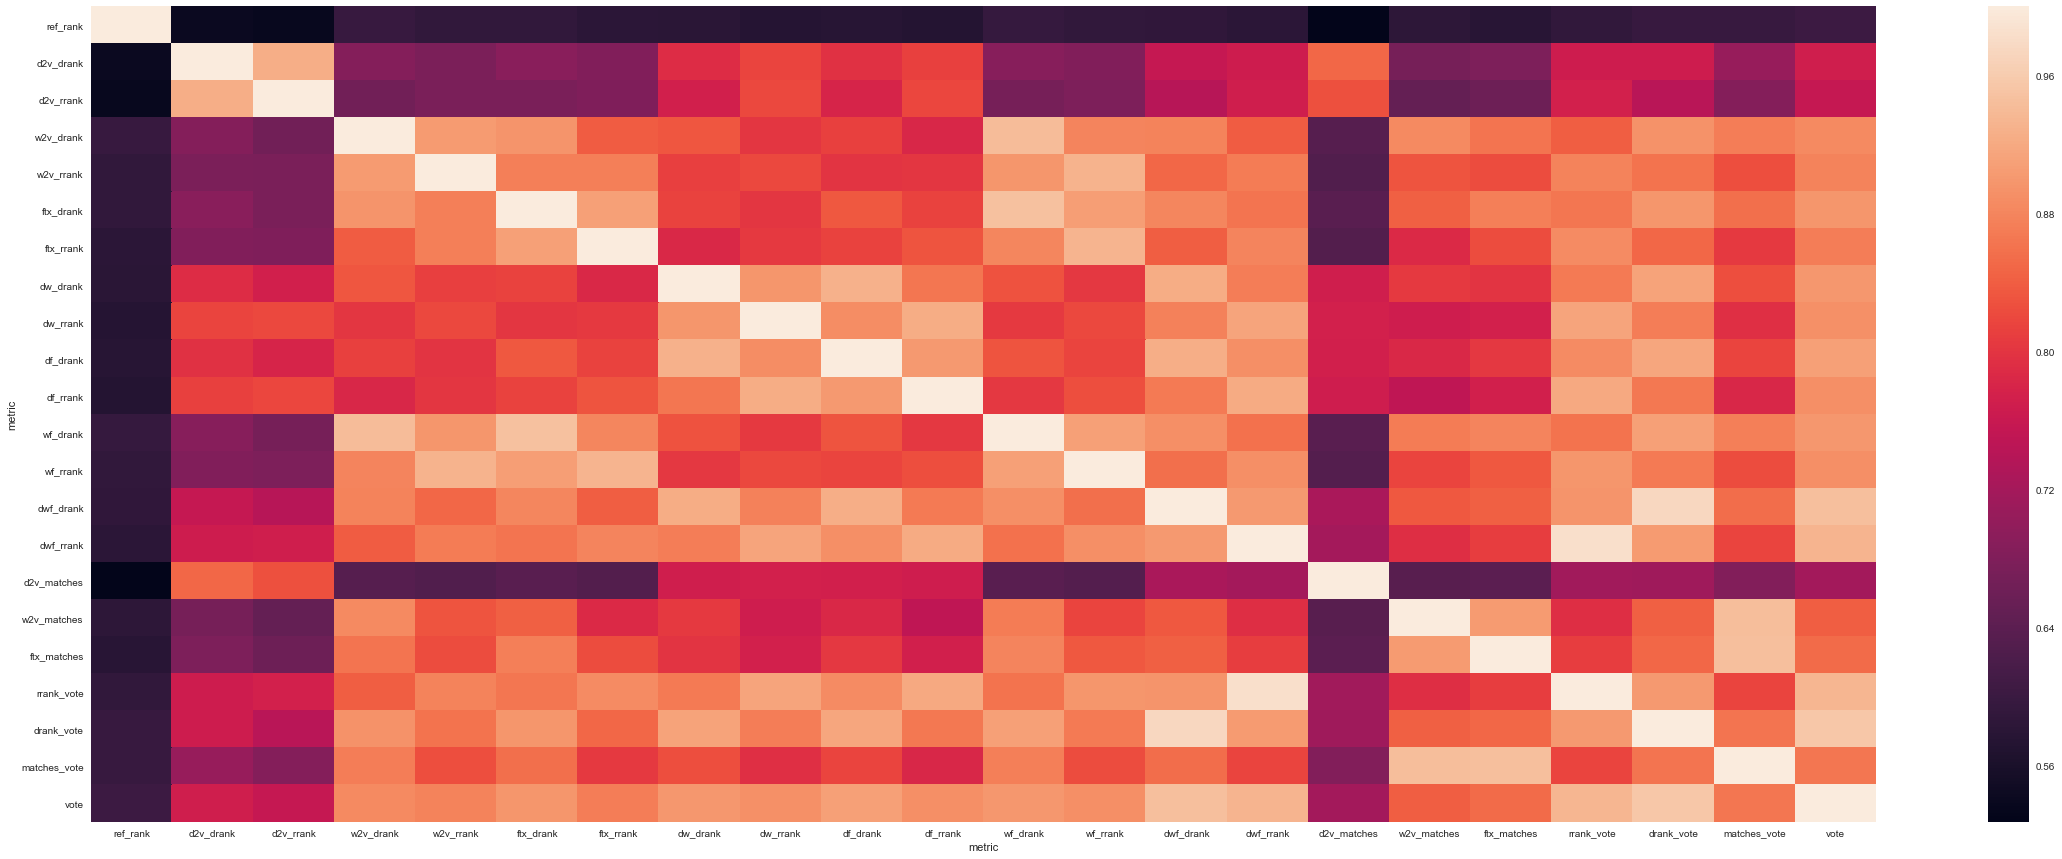

In [61]:
sns.heatmap(r)

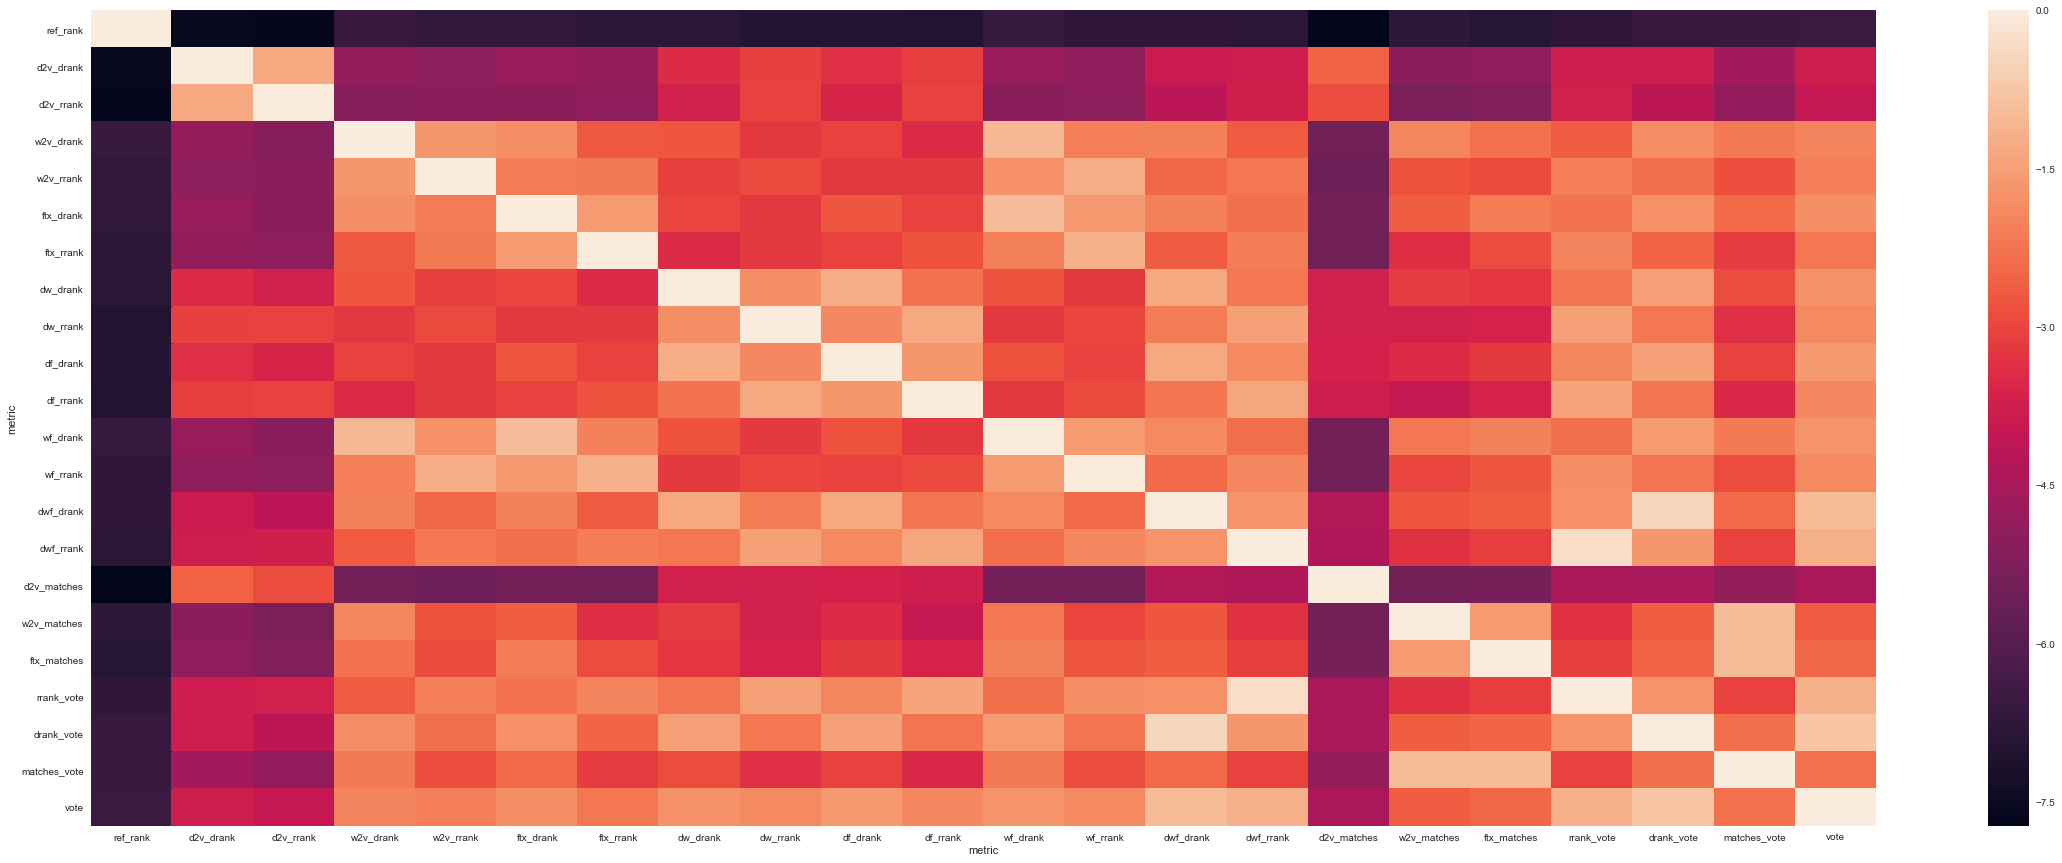

In [76]:
sns.heatmap(edit_dists * -1)